In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from matplotlib import rc # 폰트
# 유니코드 폰트 설정
rc('font', family='AppleGothic')
# 마이너스 기호 표시 설정
plt.rcParams['axes.unicode_minus'] = False

In [41]:
data = pd.read_csv('2002_2022_month(edit).csv')
data

,일시,지점,평균기온,최고기온,최저기온(°C),평균상대습도,최소상대습도
0,2002-01-01,108,0.3,13.5,-12.0,63,22
1,2002-02-01,108,2.9,12.6,-5.1,55,13
2,2002-03-01,108,7.6,19.4,-2.9,55,10
3,2002-04-01,108,13.6,27.7,4.3,53,8
4,2002-05-01,108,18.2,27.7,10.0,62,12
...,...,...,...,...,...,...,...
247,2022-08-01,108,25.7,32.9,16.1,80,39
248,2022-09-01,108,22.4,32.5,12.3,68,29
249,2022-10-01,108,14.6,27.6,4.4,69,25
250,2022-11-01,108,10.0,22.1,-8.1,65,23


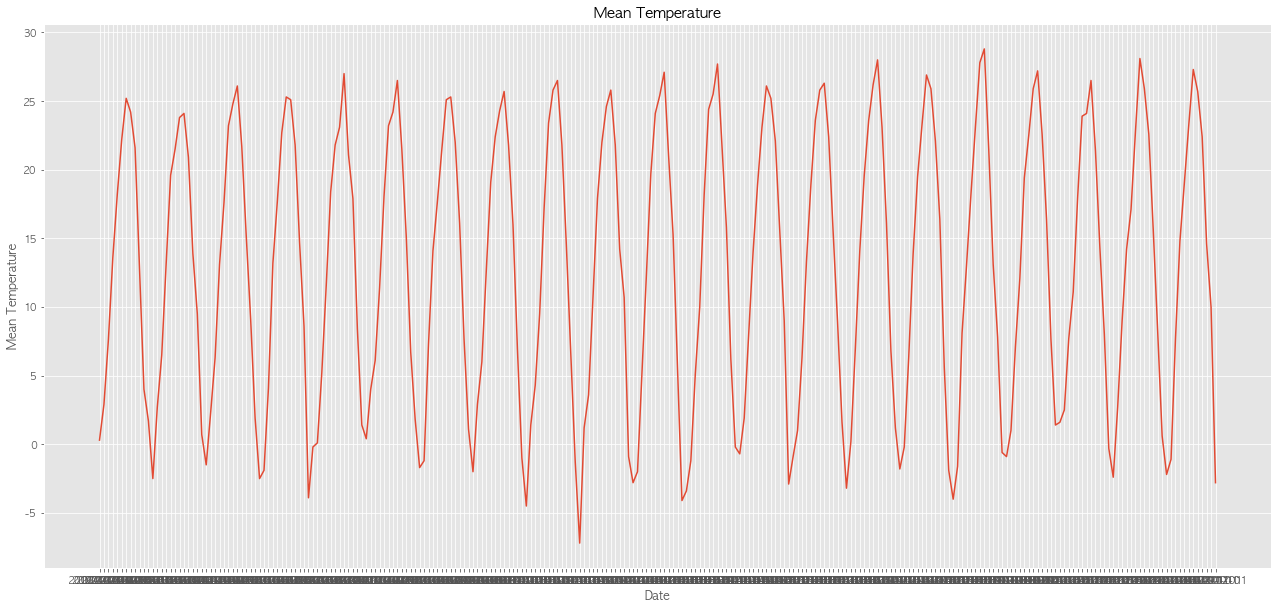

In [42]:
plt.figure(figsize=(22,10))
plt.plot(data.일시, data.평균기온)
plt.title("Mean Temperature")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [43]:
temp = data.loc[:, ["일시", "평균기온"]]
temp

,일시,평균기온
0,2002-01-01,0.3
1,2002-02-01,2.9
2,2002-03-01,7.6
3,2002-04-01,13.6
4,2002-05-01,18.2
...,...,...
247,2022-08-01,25.7
248,2022-09-01,22.4
249,2022-10-01,14.6
250,2022-11-01,10.0


In [44]:
temp.columns = ['Date', 'MeanTemp']

In [45]:
timeSeries = temp.loc[:, ["Date", "MeanTemp"]]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date", axis=1)
ts

,MeanTemp
Date,
2002-01-01,0.3
2002-02-01,2.9
2002-03-01,7.6
2002-04-01,13.6
2002-05-01,18.2
...,...
2022-08-01,25.7
2022-09-01,22.4
2022-10-01,14.6


<Figure size 432x288 with 0 Axes>

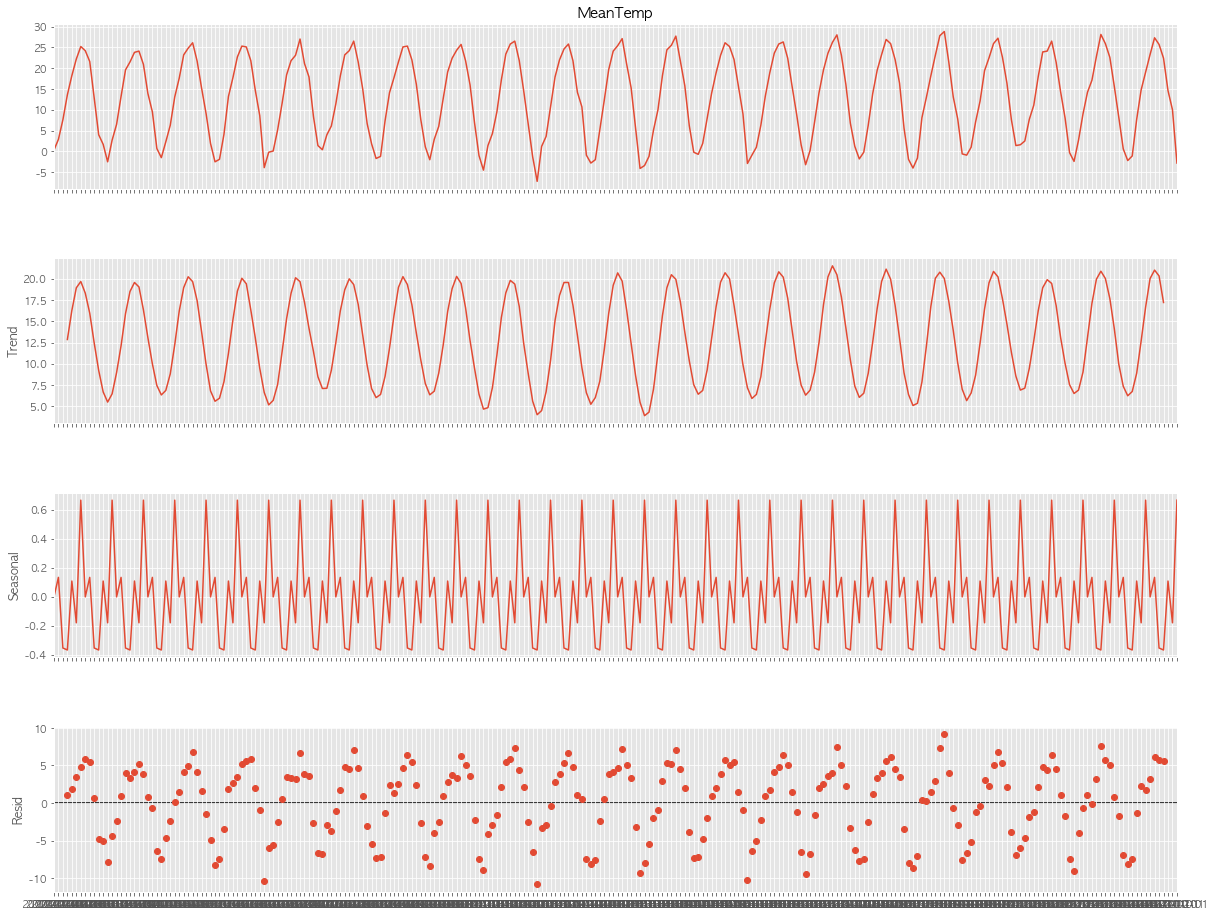

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['MeanTemp'], model = 'additive', period = 7)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

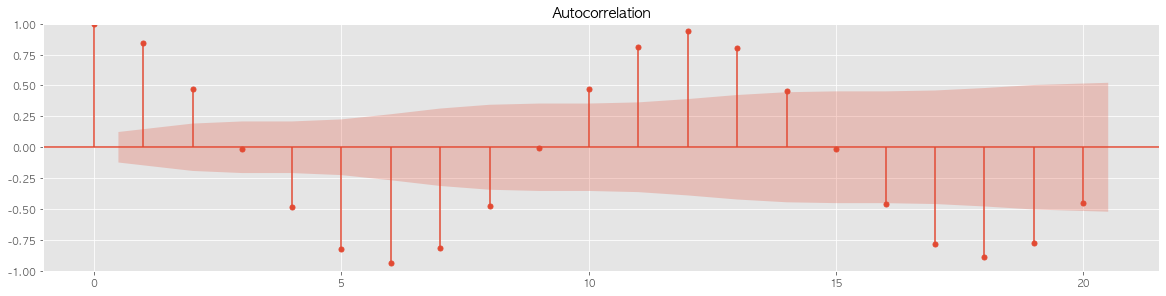

In [47]:
# ACF 그래프

import statsmodels.api as sm

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)

In [48]:
# ADF 검정으로 정상성 확인

from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.044243
p-value: 0.030964
Critical Values
	1%: -3.458
	5%: -2.874
	10%: -2.573


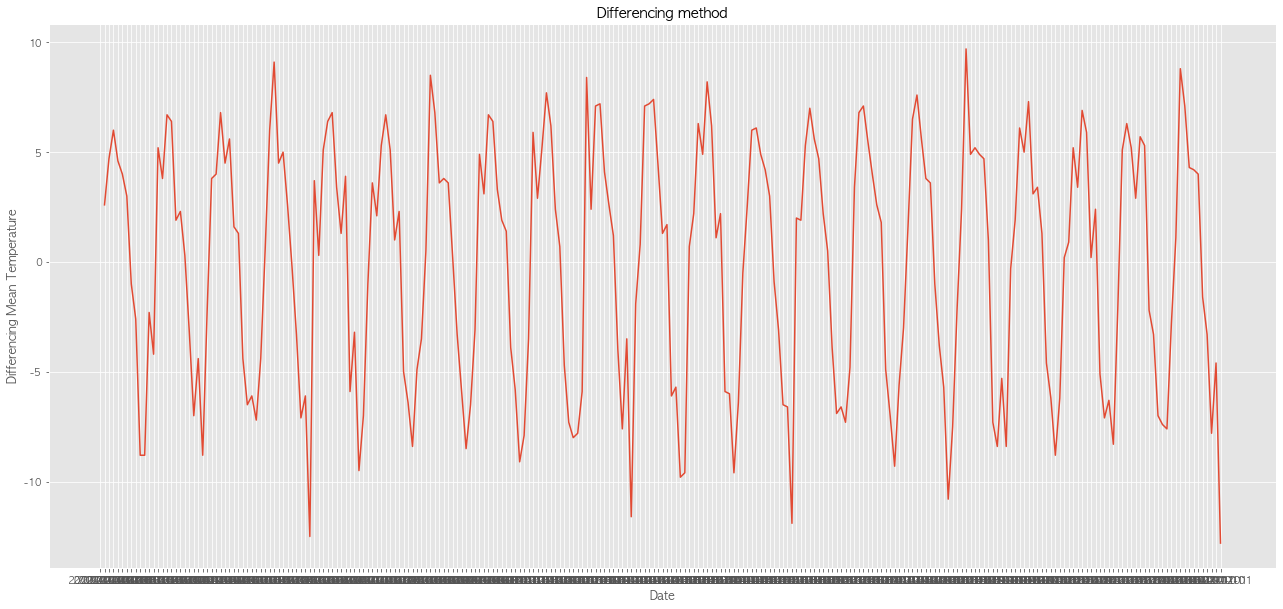

In [49]:
# 1차 차분

ts_diff = ts - ts.shift()
plt.figure(figsize=(22, 10))
plt.plot(ts_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

In [50]:
# ADF 검정으로 정상성 확인

result = adfuller(ts_diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.753773
p-value: 0.000000
Critical Values
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [51]:
# p-value가 0.05보다 작으므로 귀무가설을 기각한다 -> 1차 차분한 데이터 정상성 만족함

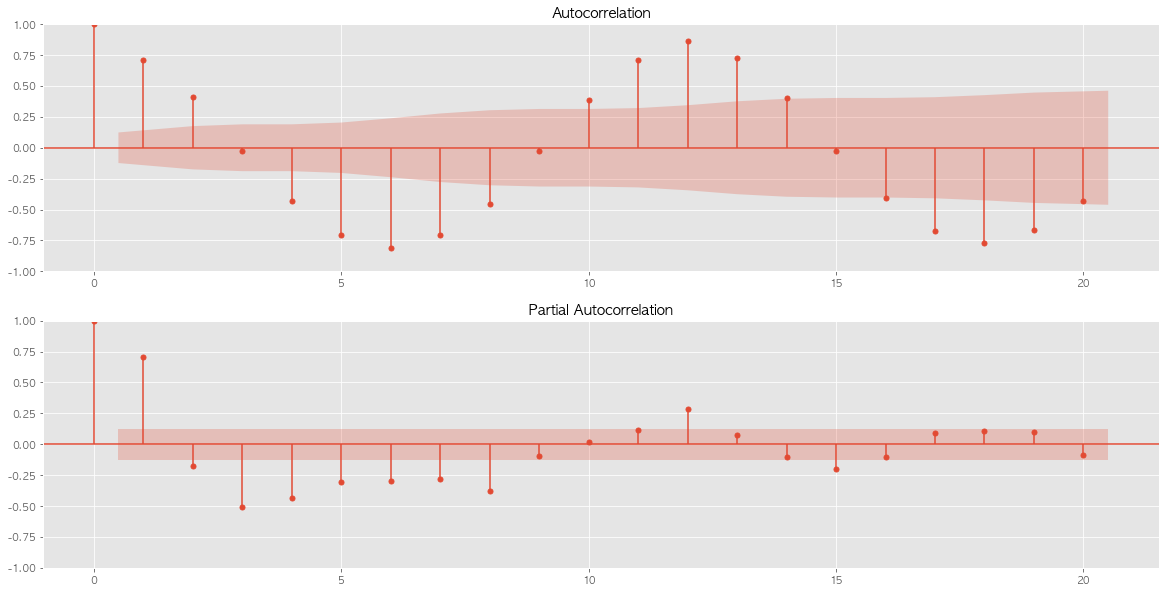

In [52]:
# 정상성을 만족하는 데이터로 ACF와 PACF 그래프를 그려 ARIMA 모형의 p와 q를 결정한다.

import statsmodels.api as sm

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)

In [53]:
timeSeries['Date'] = pd.to_datetime(timeSeries['Date'])

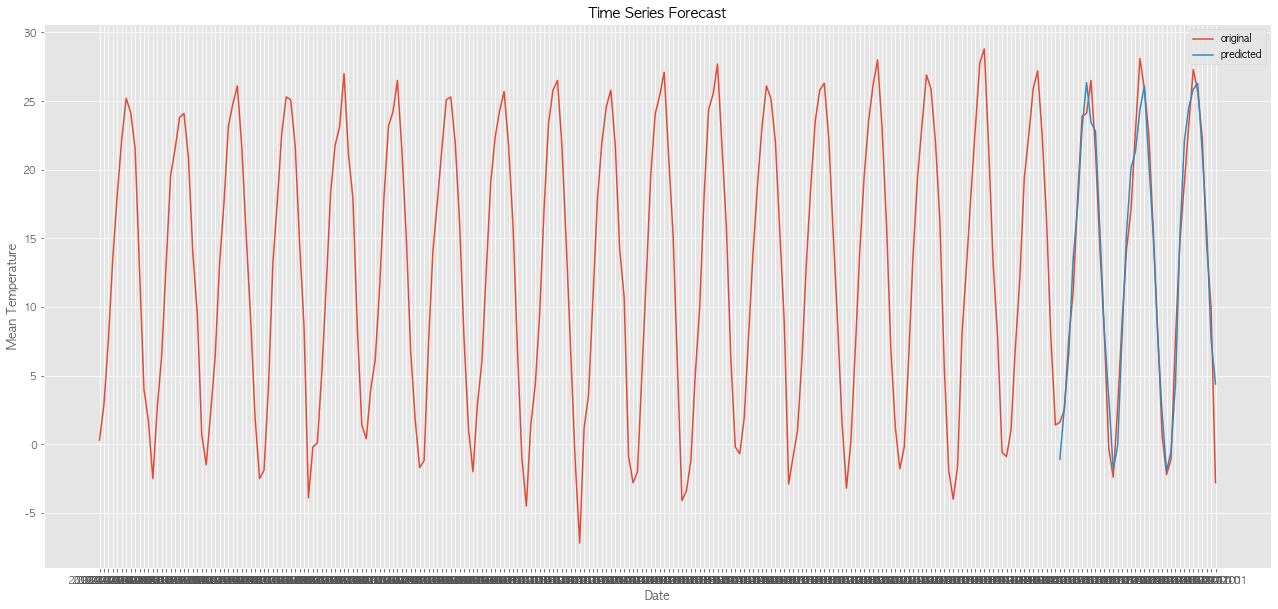

In [55]:
# ARIMA(2,1,2) 모델의 결과

from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

# fit model
model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit()

# predict
start_index = datetime(2020, 1, 1)
end_index = datetime(2022, 12, 1)
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')


# 데이터 형식 맞추기
forecast.index = temp.Date.iloc[-len(forecast):].values  # forecast의 인덱스를 temp.Date와 맞춤

# visualization
plt.figure(figsize=(22, 10))
plt.plot(temp.Date, temp.MeanTemp, label = "original")
plt.plot(forecast.index, forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


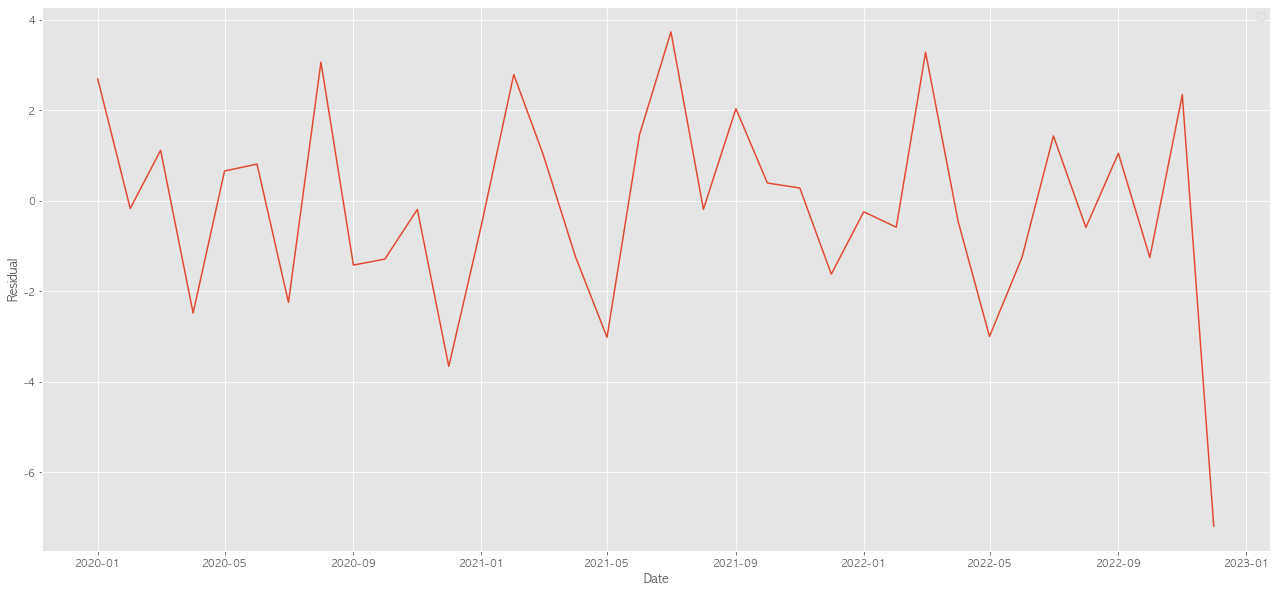

In [56]:
resi = np.array(timeSeries[timeSeries.Date>=start_index].MeanTemp) - np.array(forecast)

plt.figure(figsize=(22,10))
plt.plot(timeSeries.Date[timeSeries.Date>=start_index], resi)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

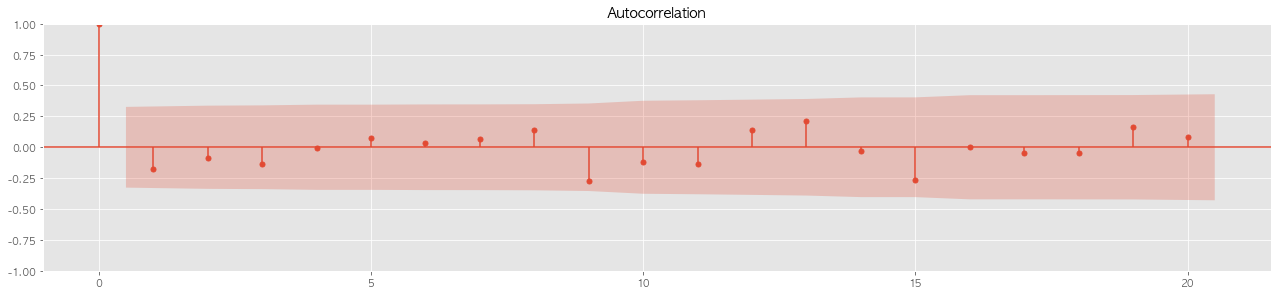

In [57]:
# ACF 그래프 및 ADF 검정을 통해 정상성 판단

fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resi, lags=20, ax=ax1)

In [58]:
result = adfuller(resi)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.295059
p-value: 0.000000
Critical Values
	1%: -3.633
	5%: -2.949
	10%: -2.613


In [59]:
# 마지막 성능 확인

from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        'R2' : r2,
        'Corr' : corr,
        'RMSE' : rmse,
        'MAPE' : mape
    }, index = [0])
    return df

In [60]:
scoring(np.array(timeSeries[timeSeries.Date>=start_index].MeanTemp), np.array(forecast))

,R2,Corr,RMSE,MAPE
0,94.949,0.975,2.201,66.115
